In [1]:
import torch

/opt/anaconda3/envs/torch8019/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


In [ ]:
ss = pd.read_csv("21ss.csv",encoding='utf-8')
print(ss.head())
print(ss.describe())

In [ ]:
aw = pd.read_csv("20aw.csv",encoding='utf-8')
print(aw.head())
print(aw.describe())

In [ ]:
aw = pd.read_table("20aw.csv",sep=',')
print(aw.head())
print(aw.describe())
print(aw.info())

In [ ]:
aw_ss = pd.concat([aw,ss],axis=0)
aw_ss = aw_ss.reset_index(drop=True)
aw_ss

In [ ]:
aw_ss.to_csv("all_sample.csv",encoding='utf-8')

In [ ]:
#把wrong變成no_fit 因為wrong也算是no_fit
all_sample=pd.read_csv("all_sample.csv",index_col=0)
all_sample['ans'] = all_sample['ans'].str.replace("wrong","not_fit")
all_sample

In [ ]:
#fit 7015,no_fit 2181, wrong 804
#all_sample=pd.read_csv("all_sample.csv")

negative_data=all_sample[all_sample["ans"]=="not_fit"]
postive_data=all_sample[all_sample["ans"]=="fit"]


#訓練2500 測試500
train_P=postive_data.sample(3000,random_state=178)
train_N=negative_data.sample(2985,random_state=198)
test_P=train_P.sample(500,random_state=73)
test_N=train_N.sample(485,random_state=65)

train_P=train_P.drop(test_P.index)
train_N=train_N.drop(test_N.index)
#source上身代碼#下身代碼
train_P=train_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
train_N=train_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_P=test_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_N=test_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)

In [ ]:
#transform可以旋轉 縮放
transform=transforms.Compose([
    transforms.Resize(224), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.CenterCrop([150,224]), #中心裁剪，从中间切出 150*224的图片
])


In [ ]:
#把秋冬跟春夏資料及底下的子資料夾所有圖片都放在一起(會有重複的圖片)
#順便把圖片名稱改成單純編號
os.mkdir("OB_imgs")
save_dir = "OB_imgs/"
aw_dir = os.listdir("20aw/fit")
ss_dir = os.listdir("21ss/fit")
aw_label = aw[['head_label','tail_label']]
ss_label = ss[['head_label','tail_label']]
t_rec = []
b_rec = []

for i,fit in enumerate(tqdm(aw_dir)):
    path = "20aw/fit/" + fit
    fit_list = os.listdir(path)
    t = aw_label.iloc[i][0]
    b = aw_label.iloc[i][1]
    if fit_list[0].startswith(t):
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
    elif fit_list[0].startswith(b):
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
    
for j,fit in enumerate(tqdm(ss_dir)):
    path = "21ss/fit/" + fit
    fit_list = os.listdir(path)
    t = ss_label.iloc[j][0]
    b = ss_label.iloc[j][1]
    if fit_list[0].startswith(t):
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
    elif fit_list[0].startswith(b):
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
    
    
    

In [ ]:
imgs=os.listdir("OB_imgs")#回傳該路徑下有哪些檔案
pbar=tqdm(total=len(imgs))
for img in imgs:
    path="OB_imgs/"+img
    pil_img=Image.open(path)
    ttt=transform(pil_img)
    save_dir="crop_img_test/"+img
    ttt.save(save_dir)
    pbar.update(1)

pbar.close()
    

In [ ]:
def v_merge_img(data_df):
    source=list(data_df["head_label"])
    target=list(data_df["tail_label"])
    type=list(data_df["ans"])[0]
    if(len(data_df)==2500 and type=="fit"):
        folder_name="train/fit"
    elif(len(data_df)==2500 and type=="not_fit"):
        folder_name="train/not_fit"
    elif(len(data_df)==500 and type=="fit"):
        folder_name="test/fit"
    elif(len(data_df)==485 and type=="not_fit"):
        folder_name="test/not_fit"

    if (os.path.exists(folder_name)==False):
        os.mkdir(folder_name)

    for i,top in enumerate(source):
        top_dir="crop_img_test/"+top+".png"
        bottom_dir="crop_img_test/"+target[i]+".png"
        #用opencv讀取圖片
        top_img = cv2.imread(top_dir)
        bottom_img = cv2.imread(bottom_dir)
        fit_img = np.vstack([top_img, bottom_img])  # 垂直拼接，變成上下兩個組圖

        fit_img_dir=folder_name+"/fit"+str(i)+".png"
        cv2.imwrite(fit_img_dir,fit_img)
        
   


In [ ]:
v_merge_img(test_P)
v_merge_img(test_N)

v_merge_img(train_P)
v_merge_img(train_N)


In [3]:
transform2=transforms.Compose([#compose可以把調整方法串接起來
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素, VGG的輸入規定格式
    transforms.ToTensor(), #將圖片或是ndarray轉換成Tensor,除255歸一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #標準化至[-1,1]其實並非到0~1之間，模型才容易收斂 mean變成0 std變成1
])

batch_size=4 #原本16，建議設2的n次方，較有效率

train_dir = "train"           
#定義數據集
train_datasets = datasets.ImageFolder(train_dir, transform=transform2)
#加載數據集
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [3]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=False)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [4]:
print(VGGNet())

/opt/anaconda3/envs/torch8019/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/anaconda3/envs/torch8019/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGGNet(
  (features): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [ ]:
#釋放無用的內存
#if hasattr(torch.cuda,'empty_cache'):
#torch.cuda.empty_cache()

In [5]:
learning_rate = 5e-5
epoch = 20

model = VGGNet()
if torch.cuda.is_available():
    model.cuda()
params = [{'params': md.parameters()} for md in model.children()
          if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

model.train()

loss_list = []
accuracy_list = []
tr_loss_list = []
tr_accuracy_list = []

for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    pbar=tqdm(total=len(train_dataloader))
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()

    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_datasets)), train_acc / (len(train_datasets))))
    tr_loss_list.append(train_loss / (len(train_datasets)))
    tr_accuracy_list.append(100 * train_acc / (len(train_datasets)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for img, label in val_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = model(img)
        loss = loss_func(out, label)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))
    loss_list.append(eval_loss / (len(val_datasets)))
    accuracy_list.append(100 * eval_acc / (len(val_datasets)))

c:\Users\YUDE ZHOU\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\YUDE ZHOU\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch 1


100%|██████████| 1250/1250 [08:30<00:00,  2.45it/s]


Train Loss: 0.173578, Acc: 0.496800
Test Loss: 0.173804, Acc: 0.507614
epoch 2


100%|██████████| 1250/1250 [08:26<00:00,  2.47it/s]


Train Loss: 0.173316, Acc: 0.496200
Test Loss: 0.173808, Acc: 0.507614
epoch 3


100%|██████████| 1250/1250 [08:27<00:00,  2.46it/s]


Train Loss: 0.173191, Acc: 0.523000
Test Loss: 0.173637, Acc: 0.508629
epoch 4


100%|██████████| 1250/1250 [08:27<00:00,  2.46it/s]


Train Loss: 0.173107, Acc: 0.520200
Test Loss: 0.172415, Acc: 0.563452
epoch 5


100%|██████████| 1250/1250 [08:26<00:00,  2.47it/s]


Train Loss: 0.172116, Acc: 0.556000
Test Loss: 0.169733, Acc: 0.617259
epoch 6


100%|██████████| 1250/1250 [08:26<00:00,  2.47it/s]


Train Loss: 0.166918, Acc: 0.599000
Test Loss: 0.161932, Acc: 0.607107
epoch 7


100%|██████████| 1250/1250 [08:27<00:00,  2.46it/s]


Train Loss: 0.159032, Acc: 0.634600
Test Loss: 0.154591, Acc: 0.657868
epoch 8


100%|██████████| 1250/1250 [08:26<00:00,  2.47it/s]


Train Loss: 0.150753, Acc: 0.671600
Test Loss: 0.149554, Acc: 0.664975
epoch 9


100%|██████████| 1250/1250 [08:25<00:00,  2.47it/s]


Train Loss: 0.138690, Acc: 0.718000
Test Loss: 0.151283, Acc: 0.668020
epoch 10


100%|██████████| 1250/1250 [08:23<00:00,  2.48it/s]


Train Loss: 0.126341, Acc: 0.749600
Test Loss: 0.150756, Acc: 0.711675
epoch 11


100%|██████████| 1250/1250 [08:26<00:00,  2.47it/s]


Train Loss: 0.113389, Acc: 0.787200
Test Loss: 0.141113, Acc: 0.728934
epoch 12


100%|██████████| 1250/1250 [08:26<00:00,  2.47it/s]


Train Loss: 0.100229, Acc: 0.811000
Test Loss: 0.139443, Acc: 0.743147
epoch 13


100%|██████████| 1250/1250 [08:23<00:00,  2.48it/s]


Train Loss: 0.089337, Acc: 0.839800
Test Loss: 0.125526, Acc: 0.777665
epoch 14


100%|██████████| 1250/1250 [08:23<00:00,  2.48it/s]


Train Loss: 0.078090, Acc: 0.866000
Test Loss: 0.129014, Acc: 0.786802
epoch 15


100%|██████████| 1250/1250 [08:24<00:00,  2.48it/s]


Train Loss: 0.065919, Acc: 0.888000
Test Loss: 0.141784, Acc: 0.781726
epoch 16


100%|██████████| 1250/1250 [08:27<00:00,  2.46it/s]


Train Loss: 0.056739, Acc: 0.911400
Test Loss: 0.165740, Acc: 0.764467
epoch 17


100%|██████████| 1250/1250 [08:23<00:00,  2.48it/s]


Train Loss: 0.045990, Acc: 0.924000
Test Loss: 0.167465, Acc: 0.771574
epoch 18


100%|██████████| 1250/1250 [08:22<00:00,  2.49it/s]


Train Loss: 0.038799, Acc: 0.939800
Test Loss: 0.210499, Acc: 0.777665
epoch 19


100%|██████████| 1250/1250 [08:23<00:00,  2.48it/s]


Train Loss: 0.032217, Acc: 0.950000
Test Loss: 0.205806, Acc: 0.779695
epoch 20


100%|██████████| 1250/1250 [08:24<00:00,  2.48it/s]


Train Loss: 0.025145, Acc: 0.963600
Test Loss: 0.237250, Acc: 0.768528


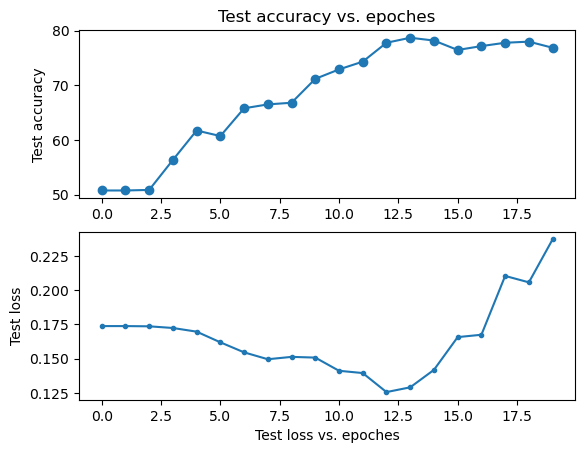

In [6]:
import matplotlib.pyplot as plt

x1 = range(0, 20)
x2 = range(0, 20)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


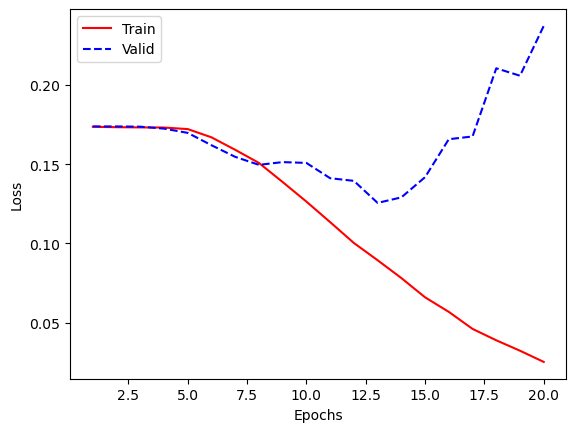

In [7]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(20)]
plt.plot(epochs,tr_loss_list, color='red', label='Train')
plt.plot(epochs,loss_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

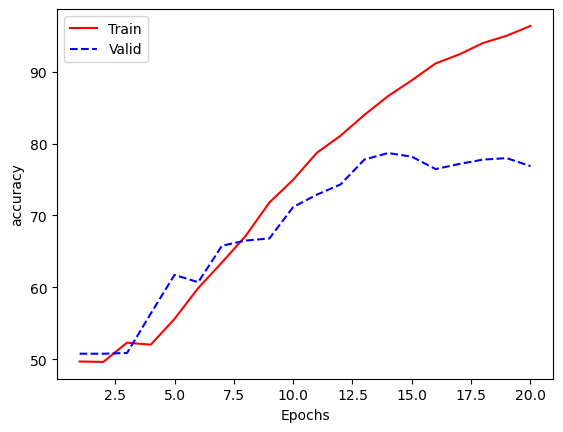

In [8]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(20)]
plt.plot(epochs,tr_accuracy_list, color='red', label='Train')
plt.plot(epochs,accuracy_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

In [ ]:
torch.save(model.state_dict(), "VGG16_96_76.pt")
